In [33]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import ternary
import warnings
import random

%matplotlib inline
warnings.filterwarnings('ignore')

# Conclusions from this notebook

### ***Note: all growth rates are net growth rates. No herbivores are included. The starting values for each run were C0 = 0.99, M0 = T0 = 0.005.***

For coral to exist at equilibirum, alpha3 cannot be higher than ~0.00429 across all values of r, beta, alpha1, and alpha2. Coral cover can exist at equilbirum when alpha3 =< ~0.01857, when gamma is sufficiently low. Thus, macroalgal overgrowth of coral (relative to turf) and/or gamma (macroalgal overgrowth of turf) must be sufficiently low for coral cover to exist at equilibrium. Next step is to include fish!

# Fung et al., 2011 parameter ranges

**Coral Growth:** $r =  0.04–0.2 yr^{-1}$  *(Fung et al., 2011)*

**Growth Rate of Macroalgae onto Free Space:** $gamma = 0.05–0.4 yr^{-1}$ *(Fung et al., 2011)*

**Growth Rate of Turf onto Free Space** $beta = 2–20 yr^{-1}$ *(Fung et al., 2011)*

**Growth rate of corals onto turf relative to the rate onto free space:** $alpha1 = 0.0-1.0$ *(Fung et al., 2011)*

**Growth rate of macroalgae onto turf relative to the rate onto free space** $alpha2 = 0–0.9$ *(Fung et al., 2011)* 

**Rate of macroalgae overgrowth onto coral relative to the rate onto free space** $alpha3 = 0–0.9$ *(Fung et al., 2011)*

In [34]:
def dNdt(t, N, r, gamma, beta, alpha1, alpha2, alpha3):
    
    C,M,T = N
    
    dC = (r*C*(1-C-M-T) + alpha1*r*C*T - alpha3*gamma*C*M)*dt
    dM = (gamma*M*(1-C-M-T) + alpha2*gamma*T*M + alpha3*gamma*C*M)*dt
    dT = (beta*T*(1-C-M-T) - alpha1*r*C*T - alpha2*gamma*T*M)*dt

    return dC, dM, dT

In [35]:
dt = 1
NUMSTEPS = 10000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

r = (0.04 + 0.2)/2 #coral growth
gamma = (0.05 + 0.4)/2 #macro algae growth rate over free space
beta = (2 + 20)/2 #turf growth rate onto free space
alpha1 = 1.0/2 #growth rate of corals onto turf relative to the rate onto free space
alpha2 = 0.9/2 #growth rate of macroalgae onto turf relative to the rate onto free space
alpha3 = 0.9/2 #rate of macroalgal overgrowth onto coral relative to the rate onto free space

C0 = 0.99
M0 = 0.005
T0 = 0.005

In [36]:
r_value = np.linspace(0.04, 0.2, 15)
r_value = np.round(r_value,5)

gamma_value = np.linspace(0.05, 0.4, 15)
gamma_value = np.round(gamma_value,5)

beta_value = np.linspace(2, 20, 15)
beta_value = np.round(beta_value,5)

alpha1_value = np.linspace(0, 1.0, 15)
alpha1_value = np.round(alpha1_value,5)

alpha2_value = np.linspace(0, 0.9, 15)
alpha2_value = np.round(alpha2_value,5)

alpha3_value = np.linspace(0, 0.020, 15)
alpha3_value = np.round(alpha3_value,5)

## Defining parcross functions (for each, change function title and placement of p1/p2)

In [37]:
# r x alpha3
def parcross_r_a3(p1_val, p2_val, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK23', 
                                args = (p1, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        p2), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
           
    df = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df)

# gamma x alpha3
def parcross_gamma_a3(p1_val, p2_val, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK23', 
                                args = (r, 
                                        p1, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        p2), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
           
    df = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df)

# beta x alpha3
def parcross_beta_a3(p1_val, p2_val, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK23', 
                                args = (r, 
                                        gamma, 
                                        p1, 
                                        alpha1, 
                                        alpha2, 
                                        p2), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
           
    df = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df)

# alpha1 x alpha3
def parcross_a1_a3(p1_val, p2_val, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK23', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        p1, 
                                        alpha2, 
                                        p2), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
           
    df = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df)

# alpha2 x alpha3
def parcross_a2_a3(p1_val, p2_val, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK23', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        p1, 
                                        p2), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
           
    df = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df)

## Heatmaps (for each, change function title, value string, & plot labels/title)

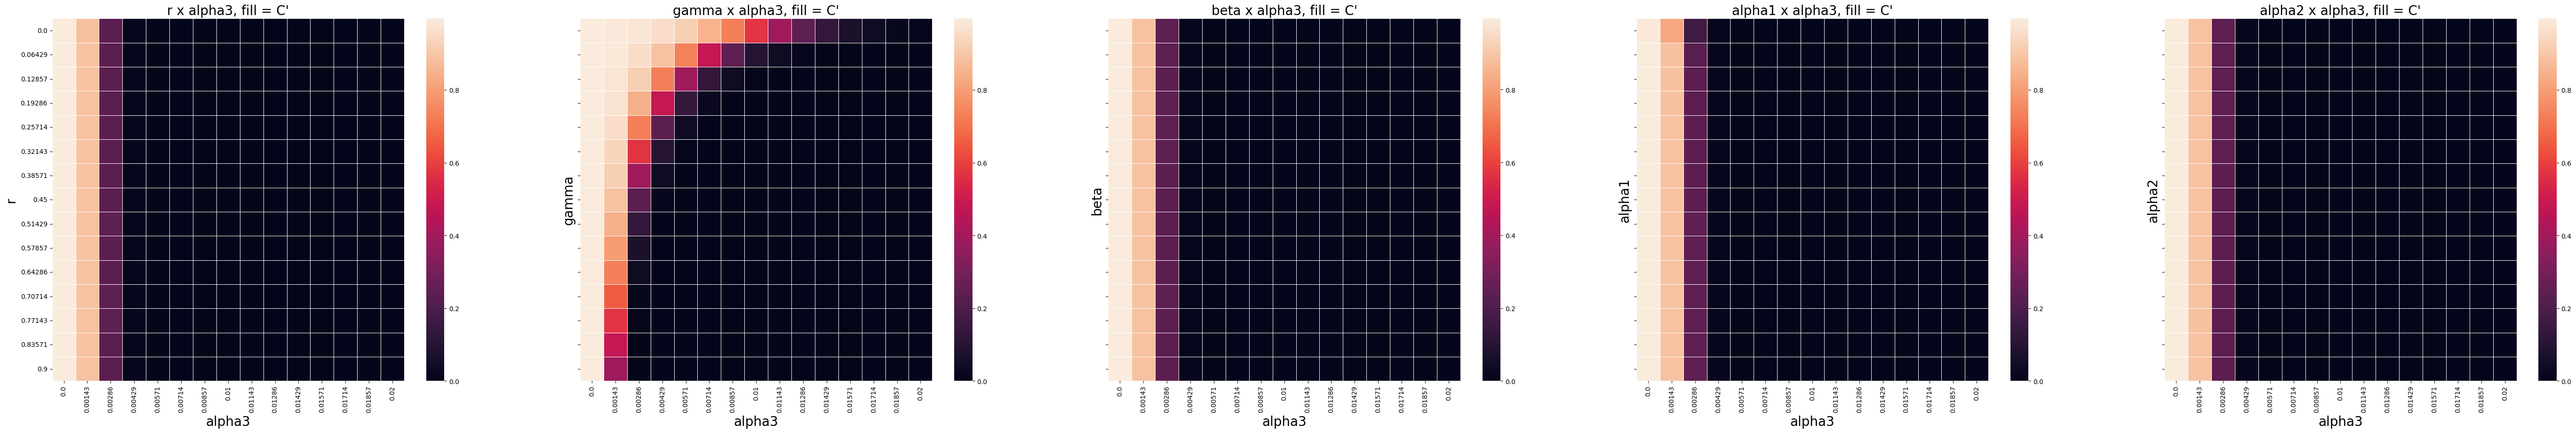

In [38]:
figure, ax = plt.subplots(ncols=5, nrows = 1, sharey=True, figsize=(70, 10))

# r x alpha3

df_r_a3 = parcross_r_a3(r_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, annot=False, linewidths=.5, ax=ax[0])
ax[0].set_xlabel('alpha3', fontsize = 20)
ax[0].set_ylabel('r', fontsize = 20)
ax[0].set_title("r x alpha3, fill = C'", fontsize = 20);

# gamma x alpha3

df = parcross_gamma_a3(gamma_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, annot=False, linewidths=.5, ax=ax[1])
ax[1].set_xlabel('alpha3', fontsize = 20)
ax[1].set_ylabel('gamma', fontsize = 20)
ax[1].set_title("gamma x alpha3, fill = C'", fontsize = 20);

# beta x alpha3

df = parcross_beta_a3(beta_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, annot=False, linewidths=.5, ax=ax[2])
ax[2].set_xlabel('alpha3', fontsize = 20)
ax[2].set_ylabel('beta', fontsize = 20)
ax[2].set_title("beta x alpha3, fill = C'", fontsize = 20);

# alpha1 x alpha3

df = parcross_a1_a3(alpha1_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, annot=False, linewidths=.5, ax=ax[3])
ax[3].set_xlabel('alpha3', fontsize = 20)
ax[3].set_ylabel('alpha1', fontsize = 20)
ax[3].set_title("alpha1 x alpha3, fill = C'", fontsize = 20);

# alpha2 x alpha3

df = parcross_a2_a3(alpha2_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, annot=False, linewidths=.5, ax=ax[4])
ax[4].set_xlabel('alpha3', fontsize = 20)
ax[4].set_ylabel('alpha2', fontsize = 20)
ax[4].set_title("alpha2 x alpha3, fill = C'", fontsize = 20);

figure.savefig('parameter cross-analyses_alpha3') 

## Finding max values of parameters that coral can exist at

In [41]:
df_r_a3 = parcross_r_a3(r_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
df_gamma_a3 = parcross_gamma_a3(gamma_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
df_beta_a3 = parcross_beta_a3(beta_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
df_a1_a3 = parcross_a1_a3(alpha1_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)
df_a2_a3 = parcross_a2_a3(alpha2_value, alpha3_value, time_points, NUMYEARS, C0, M0, T0, r, gamma, beta, alpha1, alpha2, alpha3)

In [42]:
threshold_r_alpha3 = df_r_a3[df_r_a3['C_prime'] > 0.01]

threshold_gamma_alpha3 = df_gamma_a3[df_gamma_a3['C_prime'] > 0.01]

threshold_beta_alpha3 = df_beta_a3[df_beta_a3['C_prime'] > 0.01]

threshold_alpha1_alpha3 = df_a1_a3[df_a1_a3['C_prime'] > 0.01]

threshold_alpha3_alpha2 = df_a2_a3[df_a2_a3['C_prime'] > 0.01]

In [45]:
x1 = threshold_r_alpha3['p2'].max()

x2 = threshold_gamma_alpha3['p2'].max()

x3 = threshold_beta_alpha3['p2'].max()

x4 = threshold_alpha1_alpha3['p2'].max()

x5 = threshold_alpha3_alpha2['p2'].max()

[x1,x2,x3,x4,x5]

[0.00429, 0.01857, 0.00429, 0.00429, 0.00429]